# Flow-based 

Blog : https://zhuanlan.zhihu.com/p/412836329?utm_id=0

- NICE 
- RealNVP 
- Glow 

## NICE

In [7]:
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

from torchvision import datasets, transforms

from torch.distributions.transformed_distribution import TransformedDistribution
from torch.distributions.uniform import Uniform
from torch.distributions.transforms import SigmoidTransform, AffineTransform

torch.manual_seed(0)


In [3]:
train_data = datasets.MNIST("./datasets/", 
                            download=True, 
                            train=True, 
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])
                            ]))

test_data = datasets.MNIST("./datasets/",
                           download=False,
                           transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])
                           ]))

In [4]:
class NICE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=1000):
        super().__init__()
        self.m = nn.ModuleList([nn.Sequential(
            nn.Linear(input_dim//2, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, input_dim // 2),        
        ) for _ in range(4)])
    
        self.s = nn.Parameter(torch.randn(input_dim))
    
    def forward(self, x):
        x = x.clone()
        for i in range(len(self.m)):
            x_i1 = x[:, ::2] if (i % 2) == 0 else x[:, 1::2]
            x_i2 = x[:, 1::2] if (i % 2) == 0 else x[:, ::2]
            h_i1 = x_i1
            h_i2 = x_i2 + self.m[i](x_i1)
            x = torch.empty(x.shape, device=x.device)
            x[:, ::2] = h_i1
            x[:, 1::2] = h_i2
        z = torch.exp(self.s) * x
        log_jacobian = torch.sum(self.s)
        return z, log_jacobian
    
    
    def invert(self, z):
        x = z.clone() / torch.exp(self.s)
        for i in range(len(self.m)):
            h_i1 = x[:, ::2]
            h_i2 = x[:, 1::2]
            x_i1 = h_i1
            x_i2 = h_i2 - self.m[i](x_i1)
            x = torch.empty(x.shape, device=x.device)
            x[:, ::2] = x_i1 if (i % 2) == 0 else x_i2
            x[:, 1::2] = x_i2 if (i % 2) == 0 else x_i1
        return x
        

In [5]:
## 逻辑回归分布采样

class StandardLogisticDistribution(nn.Module):
    def __init__(self, input_dim=784, device="cpu"):
        super().__init__()
        self.m = TransformedDistribution(
            base_distribution=Uniform(low=torch.zeros(input_dim, device=device),
                                      high=torch.ones(input_dim, device=device)),
            transforms=[SigmoidTransform().inv, 
                        AffineTransform(torch.zeros(input_dim, device=device),
                                        torch.ones(input_dim, device=device))]
        )

    
    def log_pdf(self, z):
        return self.m.log_prob(z).sum(dim=1)
    
    
    def sample(self):
        return self.m.sample()

In [8]:
device = "cuda"
model_flow = NICE().to(device=torch.device(device))
logistic_distribution = StandardLogisticDistribution(device=device)
optimizer = torch.optim.Adam(model_flow.parameters(), lr=0.0002, weight_decay=0.9)
dataloader = DataLoader(train_data,  batch_size=32, shuffle=True)



In [9]:
for _ in tqdm(range(10)):
    train_loss = 0
    for batch, _ in dataloader:
        batch = batch.view(-1, 28*28)
        z, log_jacobian = model_flow(batch.to(device))
        log_likelihood = logistic_distribution.log_pdf(z) + log_jacobian
        loss = -log_likelihood.sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
    
    print("train_loss: ", train_loss/len(train_data))

 10%|█         | 1/10 [00:30<04:30, 30.07s/it]

train_loss:  1063.742011263021


 20%|██        | 2/10 [01:00<04:00, 30.12s/it]

train_loss:  775.1746125976563


 30%|███       | 3/10 [01:30<03:31, 30.17s/it]

train_loss:  529.6240731282552


 40%|████      | 4/10 [02:00<03:00, 30.15s/it]

train_loss:  301.1593991861979


 50%|█████     | 5/10 [02:30<02:30, 30.16s/it]

train_loss:  91.33195688476563


 60%|██████    | 6/10 [03:00<02:00, 30.16s/it]

train_loss:  -100.91676414998372


 70%|███████   | 7/10 [03:31<01:31, 30.33s/it]

train_loss:  -273.45967678222655


 80%|████████  | 8/10 [04:02<01:00, 30.39s/it]

train_loss:  -429.06123790690106


 90%|█████████ | 9/10 [04:32<00:30, 30.50s/it]

train_loss:  -565.3201985514323


100%|██████████| 10/10 [05:03<00:00, 30.31s/it]

train_loss:  -690.3101580403646


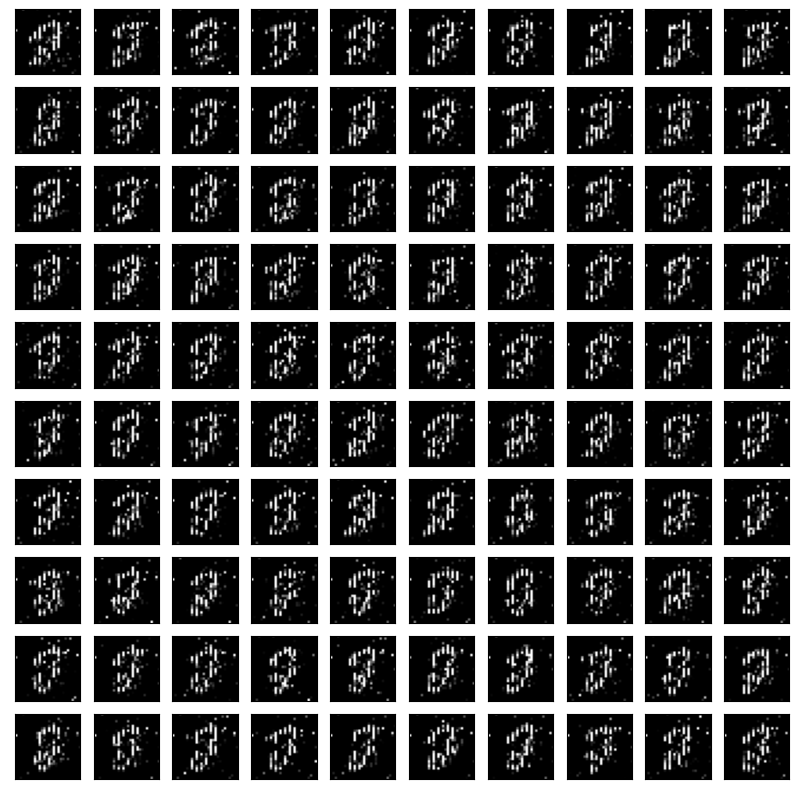

In [10]:
## 采样

nb_data = 10
fig, axs = plt.subplots(nb_data, nb_data, figsize=(10, 10))
for i in range(nb_data):
    for j in range(nb_data):
        x = model_flow.invert(logistic_distribution.sample().unsqueeze(0)).data.cpu().numpy()
        axs[i,j].imshow(x.reshape(28, 28).clip(0, 1), cmap='gray')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
plt.show()